In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fitsio
from astropy.io import fits
import pandas as pd

In [4]:
def distance(a):
    #where a is a pair of coordinates
    return np.sqrt(a[0]**2 + a[1]**2)

In [6]:
def match(a, b, return_array=False):
    #Where a and b are two matching catalogs; they are arrays of coordinate sets in form (ra,dec,mag).
    if len(a) > len(b):
        truth_cat = a
        object_cat = b
    else:
        truth_cat = b
        object_cat = a
    
    #The goal is to go through each element in the truth catalog and match it to an element in the object catalog.
    
    #Step 1: create a matching array. The matching array will be an array consisting of tuples in the following format:
            #((truth_ra,truth_dec), (obj_ra,obj_dec), distance_between_elements)
    matching_array = []
    truth_array = []
    matched_object_array = []
    distance_array = []
    
    #Step 2: calculate matches for all truth elements
    for coordinate_set in truth_cat:
        temp_cat = np.abs(object_cat - coordinate_set)
        dist_cat = list(map(distance,temp_cat))
        dist_index = np.argmin(dist_cat)
        dist = dist_cat[dist_index]
        match_coords = object_cat[dist_index]
        
        truth_array.append(coordinate_set)
        matched_object_array.append(match_coords)
        distance_array.append(dist)
        
        matching_array.append([coordinate_set, match_coords, dist])
        #So if two items in this array have the same match_coords,
        #then one of them is an observation that has been lost through blending.
    
    if return_array:
        return matching_array
    else:
        return truth_array, matched_object_array, distance_array

In [9]:
#Now we have to count the number of "lost" truth objects.
#We need to know which objects are lost, and we also need to know their magnitudes.

#The output of this function will two lists in form: [(ra,dec)] and [magnitude].
#The output will only contain lost objects. Any other objects should be ignored.

def find_lost_objects(truth_catalog, matched_catalog):
    lost_magnitude_list = []
    lost_coordinate_list = []
    match_coordinate_list = []
    
    
    truth_ra, truth_dec, truth_mag = zip(*truth_catalog)
    match_ra, match_dec, match_mag = zip(*matched_catalog)
    
    truth_ra = np.array(truth_ra)
    truth_ra = truth_ra.reshape((truth_ra.shape[0], 1))
    truth_dec = np.array(truth_dec)
    truth_dec = truth_dec.reshape((truth_dec.shape[0], 1))
    match_ra = np.array(match_ra)
    match_ra = match_ra.reshape((match_ra.shape[0], 1))
    match_dec = np.array(match_dec)
    match_dec = match_dec.reshape((match_dec.shape[0], 1))
    
    truth_coords = np.append(truth_ra, truth_dec, axis = 1)
    match_coords = np.append(match_ra, match_dec, axis = 1)
    for index in range(len(truth_coords)):
        coord = match_coords[index].tolist()
        
        if coord in match_coordinate_list:
            lost_coordinate_list.append(truth_coords[index])
            lost_magnitude_list.append(truth_mag[index])
        else:
            match_coordinate_list.append(coord)

    return lost_coordinate_list, lost_magnitude_list

# Okay now we can try this with an actual catalog.

In [13]:
import GCRCatalogs
from GCR import GCRQuery

In [14]:
# Load the blended catalog
blended_catalog = GCRCatalogs.load_catalog('dc2_object_run1.2i')

# We're going to cut the catalog for magnitude 18-24
mag_bin_1 = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('18 < mag_i_cModel'),
    GCRQuery('mag_i_cModel < 24'),
]

# Loads the blended data after cut
mag_bin_1_data = blended_catalog.get_quantities(['ra', 'dec', 'mag_i_cModel'], 
                              filters = mag_bin_1,)





#Load the true catalog
truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')

# We're going to cut the catalog for magnitude 18-24
truth_bin_1 = [
    GCRQuery('18 < i'),
    GCRQuery('i < 24'),
    GCRQuery('star == False'),
    GCRQuery('sprinkled == False'),
]

# Loads the truth data after cut
truth_bin_1_data = truth_catalog.get_quantities(['ra', 'dec', 'i'], 
                              filters = truth_bin_1,)

In [15]:
blend_data = pd.DataFrame(mag_bin_1_data) #Convert to dataframe
truth_data = pd.DataFrame(truth_bin_1_data) #Convert to dataframe

#We're going to significantly cut this data for the sake of computational speed.
blend_data = blend_data[(blend_data['ra'] > 54) & (blend_data['ra'] < 55) & \
                            (blend_data['dec'] > -30) & (blend_data['dec'] < -29)]
truth_data = truth_data[(truth_data['ra'] > 54) & (truth_data['ra'] < 55) & \
                            (truth_data['dec'] > -30) & (truth_data['dec'] < -29)]

In [16]:
print(len(blend_data))
print(len(truth_data))

#Check the lengths of the datasets. These seem reasonable.

24262
32436


In [18]:
object_catalog = np.array(blend_data.iloc[:, ::-1])
truth_catalog = np.array(truth_data.iloc[:, ::-1])

In [19]:
#Ok run the thing...
truth,matched,dist = match(object_catalog,truth_catalog)

In [20]:
lost_coords, lost_mags = find_lost_objects(truth, matched)

In [27]:
#This is the normalization code. It simply bins the lost mags set and the truth mags set, so that we can later divide them.

bins = 50
bin_size = (24-18)/50
objects_in_magnitude = []
lost_in_magnitude = []
bin_min = 18

truth_ra, truth_dec, truth_mag = zip(*truth_catalog)

for i in range(bins):
    bin_max = bin_min + bin_size
    l = list(x for x in truth_mag if bin_min <= x < bin_max)
    objects_in_magnitude.append(len(l))
    bin_min = bin_max

bin_min = 18
for i in range(bins):
    bin_max = bin_min + bin_size
    l = list(x for x in lost_mags if bin_min <= x < bin_max)
    lost_in_magnitude.append(len(l))
    bin_min = bin_max

Text(0.5, 1.0, 'Blending by Magnitude')

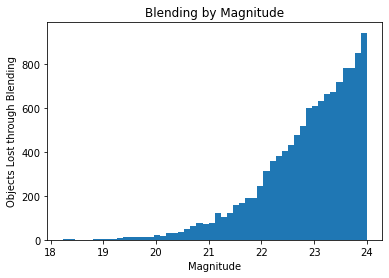

In [21]:
plt.hist(lost_mags, bins=50)
plt.xlabel('Magnitude')
plt.ylabel('Objects Lost through Blending')
plt.title('Blending by Magnitude')

Text(0, 0.5, 'Proportion of Lost Objects')

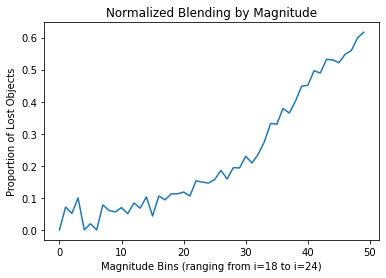

In [31]:
plt.plot(np.divide(lost_in_magnitude,objects_in_magnitude))
plt.title('Normalized Blending by Magnitude')
plt.xlabel('Magnitude Bins (ranging from i=18 to i=24)')
plt.ylabel('Proportion of Lost Objects')